# ITS Analysis Package の使用例

このノートブックは、ITAS_mock.py のサンプルデータを使って作成したITS Analysis Packageの使用方法を示します。

## 目次
1. [Cigar Data を使った ITS分析の例](#cigar-data)
2. [合成データを使った ITS分析の例](#synthetic-data)
3. [最も簡単な使用例](#simple-example)


## 基本的な考え

$$
y_t = \beta_0 + \beta_1 t + \beta_2 D_t + \beta_3 \Delta_t + \sum_{j=1}^{p} \eta_j X_{j,t} +\epsilon_j
$$

ここで、
- $y_t$: 時点 $t$ におけるアウトカム
- $t$: 時点
- $D_t$: 介入が行われた後の時点では1、それ以前の時点では0
- $\Delta_t$: 介入後の時点における時間の経過を表す
- $X_{j,t}$: 共変量
- $\epsilon_t$: 誤差項

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 作成したクラスをインポート
from module.its_analysis import ITSDataPreprocessor, ITSModel, ITSVisualizer

# プロット設定
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("ITS Analysis Package の使用例ノートブックへようこそ！")

ITS Analysis Package の使用例ノートブックへようこそ！


## 1. Cigar Data を使った ITS分析の例 {#cigar-data}

statsmodelsのCigarデータセットを使用して、元のITAS_mock.pyと同等の分析を実行します。

In [2]:
print("=== Cigar Data を使った ITS分析の例 ===")

# 1. データの読み込み（ITAS_mock.pyと同じデータ）
cigar = sm.datasets.get_rdataset("Cigar", "Ecdat").data
print(f"元データの形状: {cigar.shape}")
print(f"データの期間: {cigar['year'].min()} - {cigar['year'].max()}")
print(f"州の数: {cigar['state'].nunique()}")

# データの絞り込み（ITAS_mock.pyと同様）
target_states = [3, 5]
condition = (
    (cigar['year'] >= 70) &
    (cigar['state'].isin(target_states))
)
cigar_filtered = cigar[condition].copy().reset_index(drop=True)
print(f"フィルタ後のデータ形状: {cigar_filtered.shape}")

# データの確認
display(cigar_filtered.head())

=== Cigar Data を使った ITS分析の例 ===
元データの形状: (1380, 9)
データの期間: 63 - 92
州の数: 46
フィルタ後のデータ形状: (46, 9)


,state,year,price,pop,pop16,cpi,ndi,sales,pimin
0,3,70,37.1,1772.0,1226.6,38.8,3269.815641,115.2,34.6
1,3,71,38.5,1878.0,1313.5,40.5,3549.701945,109.6,36.6
2,3,72,38.0,1975.0,1393.6,41.8,3800.670107,125.0,37.2
3,3,73,38.7,2075.0,1476.5,44.4,4219.983168,128.3,36.5
4,3,74,39.2,2156.0,1547.0,49.3,4508.131798,133.1,37.8


In [3]:
# 2. ITSデータの前処理
preprocessor = ITSDataPreprocessor(
    time_column='year',
    intervention_point=78,  # 1978年に介入
    group_column='state'
)

processed_data = preprocessor.fit_transform(cigar_filtered)
print(f"処理後のデータ形状: {processed_data.shape}")
print("作成された変数:", preprocessor.get_its_variables())

# データの確認
print("\n処理後データのサンプル:")
display(processed_data[['year', 'state', 't', 'T', 'D', 'time_after', 'sales']].head(30))

処理後のデータ形状: (46, 14)
作成された変数: ['const', 't', 'D', 'time_after']

処理後データのサンプル:


,year,state,t,T,D,time_after,sales
0,70,3,1,0,0,0,115.2
1,71,3,2,0,0,0,109.6
2,72,3,3,0,0,0,125.0
3,73,3,4,0,0,0,128.3
4,74,3,5,0,0,0,133.1
5,75,3,6,0,0,0,121.8
6,76,3,7,0,0,0,122.3
7,77,3,8,0,0,0,121.7
8,78,3,9,1,1,1,124.7
9,79,3,10,0,1,2,124.6


In [4]:
# 3. ITSモデルの実行
model = ITSModel(
    time_column='year',
    intervention_point=78,
    group_column='state'
)

# 州を共変量として含めてモデル実行
results = model.fit(
    processed_data, 
    target_column='sales',
    covariates=['state']
)

print("\n=== モデル結果のサマリー ===")
model.summary()


=== モデル結果のサマリー ===
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     41.59
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           6.47e-14
Time:                        10:56:11   Log-Likelihood:                -137.94
No. Observations:                  46   AIC:                             285.9
Df Residuals:                      41   BIC:                             295.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        124.3648      6.060

In [5]:
# 4. 予測値の取得
predictions = model.predict(return_ci=True)
print(f"予測値の形状: {predictions.shape}")
print("予測値の列:", predictions.columns.tolist())

# 係数の解釈
print("\n=== 係数の解釈 ===")
params = results.params
pvalues = results.pvalues

print(f"切片 (const): {params['const']:.2f} (p={pvalues['const']:.3f})")
print(f"介入前トレンド (t): {params['t']:.2f} (p={pvalues['t']:.3f})")
print(f"介入レベル効果 (D): {params['D']:.2f} (p={pvalues['D']:.3f})")
print(f"介入トレンド効果 (time_after): {params['time_after']:.2f} (p={pvalues['time_after']:.3f})")

予測値の形状: (46, 6)
予測値の列: ['mean', 'mean_se', 'mean_ci_lower', 'mean_ci_upper', 'obs_ci_lower', 'obs_ci_upper']

=== 係数の解釈 ===
切片 (const): 124.36 (p=0.000)
介入前トレンド (t): 1.05 (p=0.187)
介入レベル効果 (D): 5.57 (p=0.065)
介入トレンド効果 (time_after): -4.75 (p=0.000)


図を保存しました: output/cigar_its_analysis.png


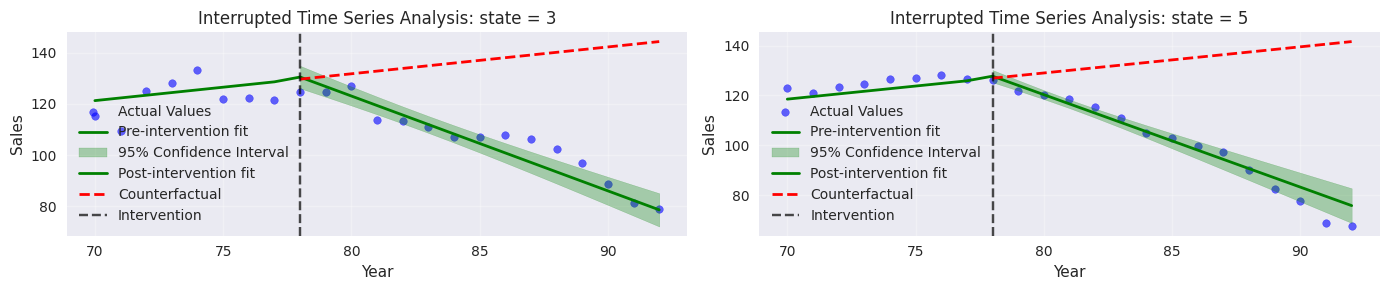

In [6]:
# 5. 可視化
visualizer = ITSVisualizer(model)

# グループ別の可視化
fig = visualizer.plot(
    group_column='state',
    figsize=(14, 6),
    save_path='output/cigar_its_analysis.png',
    show_counterfactual=True,
    show_confidence_interval=True
)

plt.show()

In [ ]:
# 6. モデルの保存
model.save_model('models/cigar_its_model.pkl')
print("モデルを 'models/cigar_its_model.pkl' に保存しました")

## 2. 合成データを使った ITS分析の例 {#synthetic-data}

複数のグループと共変量を含む合成データを使用して、より複雑な分析例を示します。

In [7]:
print("=== 合成データを使った ITS分析の例 ===")

# 1. 合成データの作成
np.random.seed(42)

# パラメータ設定
n_pre = 20   # 介入前の期間数
n_post = 20  # 介入後の期間数
n_groups = 3 # グループ数

baseline = 100
trend = 2.0
intervention_level_change = 15
intervention_trend_change = -1.0
noise_std = 8

data_list = []

for group_id in ['Group_A', 'Group_B', 'Group_C']:
    # 各グループのデータ生成
    time_points = np.arange(1, n_pre + n_post + 1)
    
    # ベースライン + トレンド
    values = baseline + trend * time_points
    
    # 介入効果（レベルシフト + トレンド変化）
    post_intervention_mask = time_points > n_pre
    values[post_intervention_mask] += intervention_level_change
    values[post_intervention_mask] += intervention_trend_change * (time_points[post_intervention_mask] - n_pre)
    
    # グループ別の効果（例として）
    if group_id == 'Group_B':
        values += 20  # Group_Bは全体的に高い
    elif group_id == 'Group_C':
        values += 10  # Group_Cは中程度
    
    # ノイズの追加
    values += np.random.normal(0, noise_std, len(values))
    
    # データフレームに追加
    for i, time_point in enumerate(time_points):
        data_list.append({
            'time': time_point,
            'group': group_id,
            'outcome': values[i],
            'covariate_1': np.random.normal(50, 10),  # 連続共変量
            'covariate_2': np.random.choice(['Type1', 'Type2'], p=[0.6, 0.4])  # カテゴリカル共変量
        })

synthetic_data = pd.DataFrame(data_list)
print(f"合成データの形状: {synthetic_data.shape}")
print(f"時間の範囲: {synthetic_data['time'].min()} - {synthetic_data['time'].max()}")
print(f"グループ: {synthetic_data['group'].unique()}")

display(synthetic_data.head())

=== 合成データを使った ITS分析の例 ===
合成データの形状: (120, 5)
時間の範囲: 1 - 40
グループ: ['Group_A' 'Group_B' 'Group_C']


,time,group,outcome,covariate_1,covariate_2
0,1,Group_A,105.973713,57.384666,Type1
1,2,Group_A,102.893886,51.713683,Type1
2,3,Group_A,111.181508,48.843517,Type1
3,4,Group_A,120.184239,46.988963,Type1
4,5,Group_A,108.126773,45.393612,Type1


In [8]:
# 2. ITSモデルの適用
model_synthetic = ITSModel(
    time_column='time',
    intervention_point=n_pre + 1,  # 21時点目に介入
    group_column='group'
)

# 複数の共変量を含めてフィット
results_synthetic = model_synthetic.fit(
    synthetic_data,
    target_column='outcome',
    covariates=['group', 'covariate_1', 'covariate_2']
)

print("\n=== 合成データのモデル結果 ===")
model_synthetic.summary()


=== 合成データのモデル結果 ===
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     281.7
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           5.29e-68
Time:                        10:57:16   Log-Likelihood:                -416.25
No. Observations:                 120   AIC:                             848.5
Df Residuals:                     112   BIC:                             870.8
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const            

図を保存しました: output/synthetic_its_analysis.png


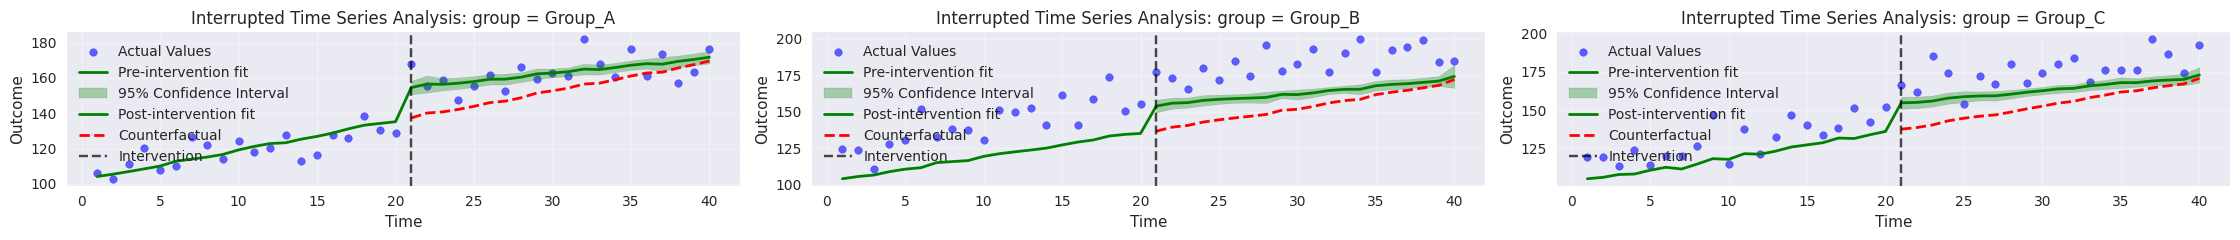

In [9]:
# 3. 可視化
visualizer_synthetic = ITSVisualizer(model_synthetic)

fig = visualizer_synthetic.plot(
    group_column='group',
    figsize=(15, 5),
    save_path='output/synthetic_its_analysis.png',
    show_counterfactual=True,
    show_confidence_interval=True
)

plt.show()

In [ ]:
# 4. モデルの保存と読み込みのテスト
model_synthetic.save_model('models/synthetic_its_model.pkl')

# 新しいモデルインスタンスで読み込み
loaded_model = ITSModel('dummy', 999)
loaded_model.load_model('models/synthetic_its_model.pkl')

# 予測結果が同じかチェック
original_pred = model_synthetic.predict()
loaded_pred = loaded_model.predict()

print(f"元モデルと読み込みモデルの予測値の差の最大値: {np.abs(original_pred - loaded_pred).max():.10f}")
print("✅ モデルの保存・読み込みが正常に完了しました")

## 3. 最も簡単な使用例 {#simple-example}

最小限のコードでITS分析を実行する例です。

=== 最も簡単な使用例 ===
データの概要:


,time,value
count,30.000000,30.000000
mean,15.500000,12.589428
std,8.803408,3.830976
min,1.000000,5.146642
25%,8.250000,9.119571
50%,15.500000,12.757326
75%,22.750000,15.509245
max,30.000000,19.411860


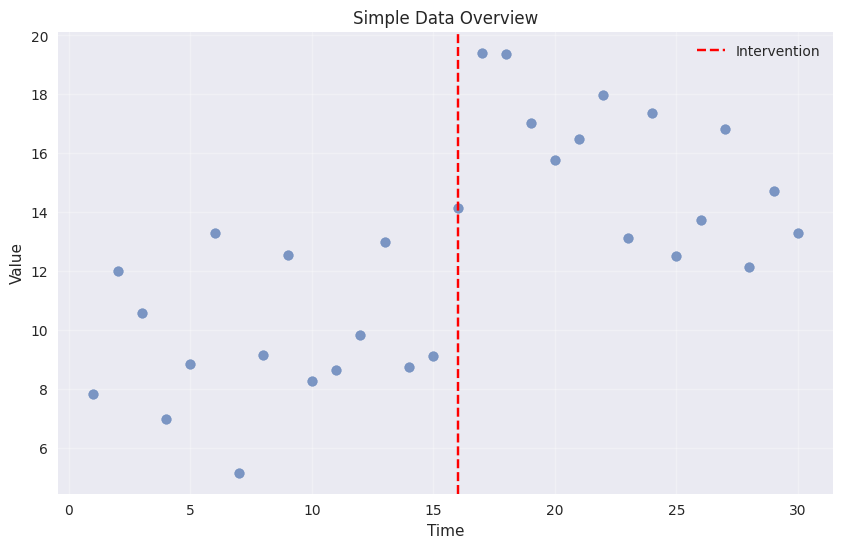

In [10]:
print("=== 最も簡単な使用例 ===")

# シンプルなデータ作成
np.random.seed(123)
simple_data = pd.DataFrame({
    'time': range(1, 31),  # 30期間
    'value': np.concatenate([
        np.random.normal(10, 2, 15),  # 介入前
        np.random.normal(15, 2, 15)   # 介入後（効果あり）
    ])
})

print("データの概要:")
display(simple_data.describe())

# データの可視化
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(simple_data['time'], simple_data['value'], alpha=0.7)
ax.axvline(x=16, color='red', linestyle='--', label='Intervention')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Simple Data Overview')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [11]:
# ワンライナーで分析完了
model_simple = ITSModel('time', intervention_point=16)
results_simple = model_simple.fit(simple_data, target_column='value')

# 結果の表示
print("簡単な分析結果:")
print(f"介入効果 (D係数): {results_simple.params['D']:.3f} (p={results_simple.pvalues['D']:.3f})")
print(f"介入前トレンド (t係数): {results_simple.params['t']:.3f} (p={results_simple.pvalues['t']:.3f})")
print(f"介入後トレンド変化 (time_after係数): {results_simple.params['time_after']:.3f} (p={results_simple.pvalues['time_after']:.3f})")

簡単な分析結果:
介入効果 (D係数): 8.211 (p=0.000)
介入前トレンド (t係数): 0.034 (p=0.510)
介入後トレンド変化 (time_after係数): -0.340 (p=0.000)


図を保存しました: output/simple_its_example.png


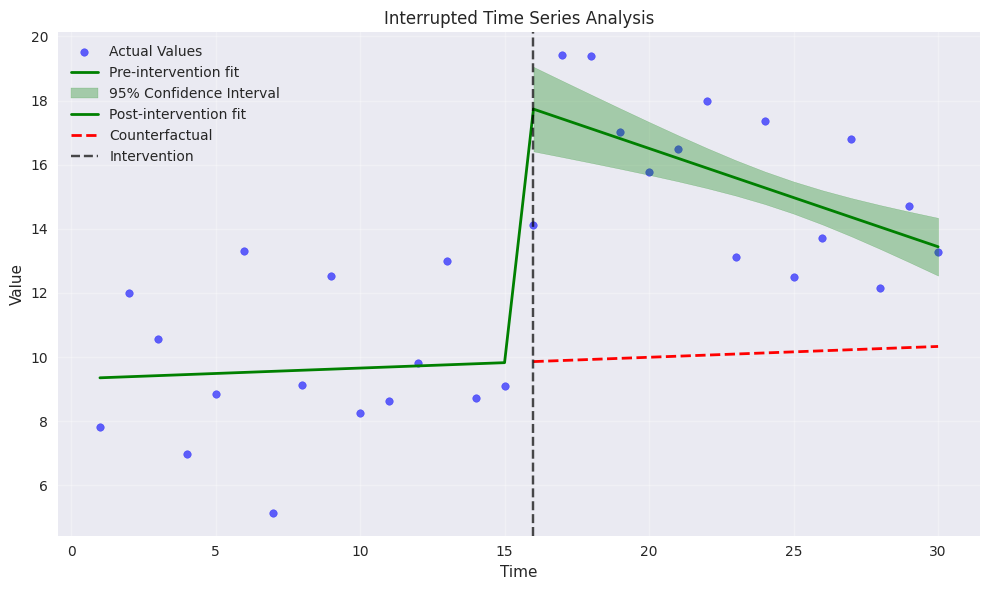

In [12]:
# 簡単な可視化
visualizer_simple = ITSVisualizer(model_simple)
fig = visualizer_simple.plot(
    figsize=(10, 6), 
    save_path='output/simple_its_example.png'
)
plt.show()

In [ ]:
# 最終確認
print("=== 全ての例が正常に完了しました ===")
print("作成されたファイル:")
output_files = [
    'output/cigar_its_analysis.png', 
    'output/synthetic_its_analysis.png',
    'output/simple_its_example.png'
]
model_files = [
    'models/cigar_its_model.pkl',
    'models/synthetic_its_model.pkl'
]

for filename in output_files + model_files:
    if Path(filename).exists():
        print(f"  ✅ {filename}")
    else:
        print(f"  ❌ {filename} (作成されませんでした)")

print("\n🎉 ITS Analysis Package の使用例ノートブックが完了しました！")